<a href="https://colab.research.google.com/github/kayserim/prj_id/blob/main/tune.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount("/content/drive")
%cd '/content/drive/MyDrive/cse6250_proj' 

In [ ]:
#W&B Setup
!pip install wandb
import wandb
wandb.login()

In [15]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
import torch.optim as optim
import pandas as pd

from utils import train, evaluate, load_dataset
from mymodels import MyLR, MyLSTM

USE_CUDA = True  # Set 'True' if you want to use GPU
NUM_WORKERS = 0  # Number of threads used by DataLoader. You can adjust this according to your machine spec.
MODEL_TYPE = 'LSTM' #LR, LSTM, LSTMCNN 
SWEEP_CNT = 3


In [16]:
# mostly taken from trainseizure.py
def train_model(config=None): 
	# Set a correct path to the seizure data file you downloaded
	PATH_TRAIN_FILE = "./data/all/XY_train_LITE.csv"
	PATH_VALID_FILE = "./data/all/XY_validation_LITE.csv"
	PATH_TEST_FILE = "./data/all/XY_test_LITE.csv"

	HOURS_LIMIT = 48
	
	with wandb.init(config=config):
		config = wandb.config
		device = torch.device("cuda" if USE_CUDA and torch.cuda.is_available() else "cpu")
		if device.type == "cuda":
			torch.backends.cudnn.deterministic = True
			torch.backends.cudnn.benchmark = False

		num_features, train_dataset = load_dataset(PATH_TRAIN_FILE, config.MODEL_TYPE, HOURS_LIMIT)
		_, valid_dataset = load_dataset(PATH_VALID_FILE, config.MODEL_TYPE, HOURS_LIMIT)
			
		train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=config.BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS)
		valid_loader = torch.utils.data.DataLoader(valid_dataset, batch_size=config.BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS)
			
		if config.MODEL_TYPE == 'LR':
			model = MyLR(num_features)
		elif config.MODEL_TYPE == 'LSTM':
			model = MyLSTM(num_features, config)
		elif config.MODEL_TYPE == 'LSTMCNN':
			raise AssertionError("Model Type Not Implemented Yet!")
		else:
			raise AssertionError("Wrong Model Type!")

		criterion = nn.CrossEntropyLoss()
		optimizer = optim.Adam(model.parameters(), lr=config.LR)
	
		wandb.watch(model, criterion, log="all", log_freq=10)

		model.to(device)
		criterion.to(device)

		best_val_acc = 0.0
		best_model =  None
		for epoch in range(config.NUM_EPOCHS):
			train_loss, train_accuracy = train(model, device, train_loader, criterion, optimizer, epoch)
			valid_loss, valid_accuracy, _ = evaluate(model, device, valid_loader, criterion)
	 
			wandb.log({"train_loss": train_loss, "epoch": epoch})
			wandb.log({"train_accuracy": train_accuracy, "epoch": epoch})
			wandb.log({"valid_loss": valid_loss, "epoch": epoch})
			wandb.log({"valid_accuracy": valid_accuracy, "epoch": epoch})
			

In [17]:
sweep_config = {
    'method': 'random', 
    'metric': {'goal': 'minimize', 'name': 'valid_loss'},
    }

parameters_dict = {
   'LR': {
        'distribution': 'log_uniform_values',
        'min': 0.0001,
        'max': 0.002
    },    
    'NUM_EPOCHS' :{
      'distribution': 'q_log_uniform_values',
      'min': 4,
      'max': 64,
      'q': 4     
    },
    'BATCH_SIZE' :{
      'distribution': 'q_log_uniform_values',
      'min': 4,
      'max': 64,
      'q': 2      
    },
    'LSTM_HIDDEN_SIZE' :{
      'distribution': 'q_log_uniform_values',
      'min': 8,
      'max': 128,
      'q': 4      
    },
    'LSTM_DROPOUT' :{
      'distribution': 'uniform',
      'min': 0,
      'max': 0.4  
    },
}

#parameters not for sweep but recording here anyways
parameters_dict.update({
    'MODEL_TYPE': {
        'value': MODEL_TYPE },
    'LSTM_NUM_LAYERS' :{
        'value': 3},
    })

sweep_config['parameters'] = parameters_dict



In [ ]:
#Initialize a hyperparameter sweep. 
sweep_id = wandb.sweep(sweep_config, project = 'test10')

#Run Client
wandb.agent(sweep_id, train_model, count=SWEEP_CNT)

example output from weights & biases:
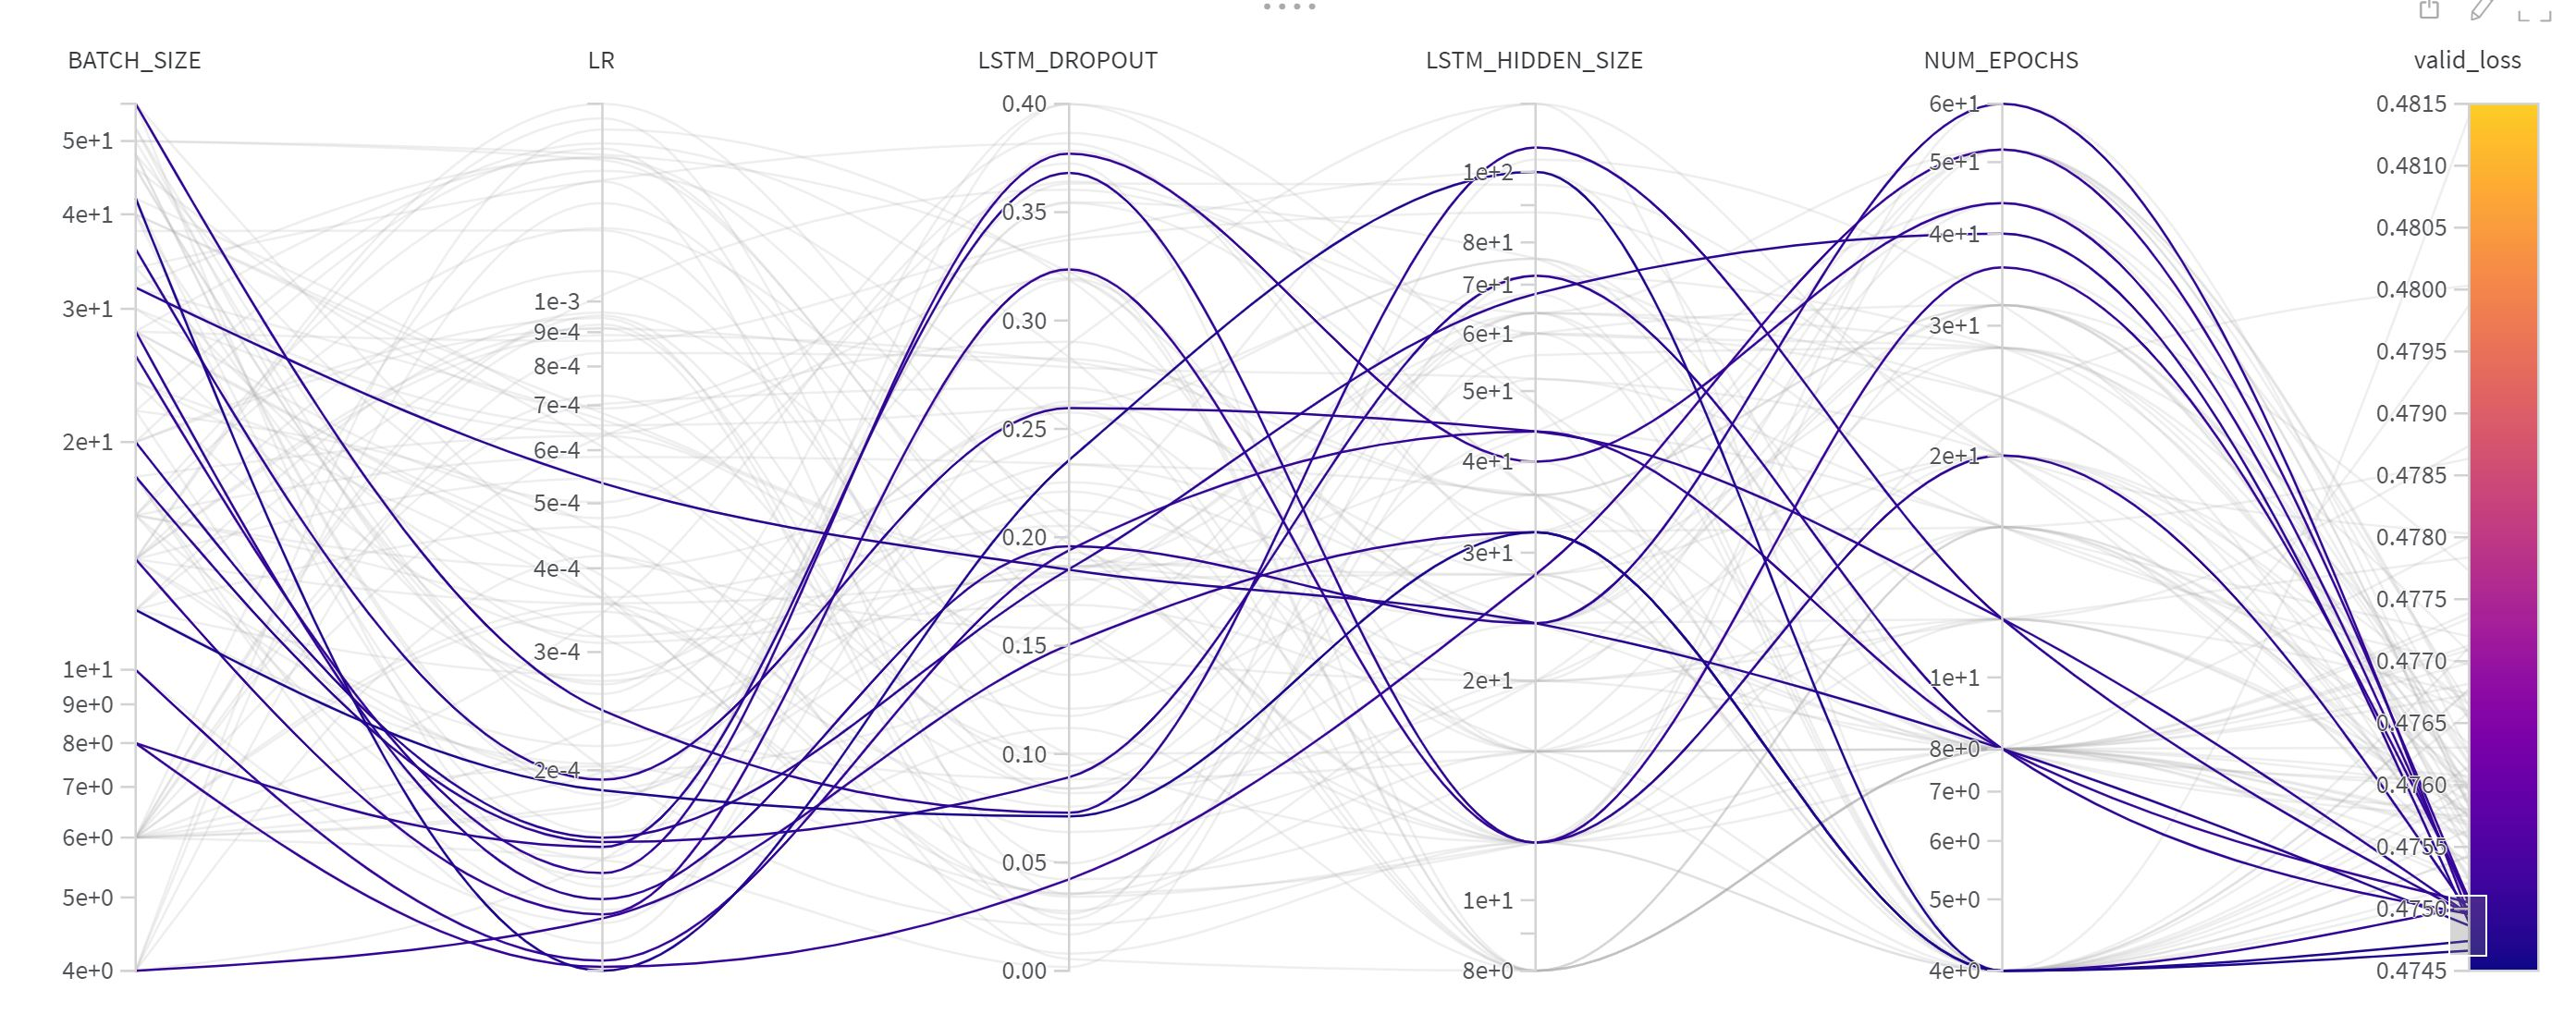